# Analyze the Result of gem5 Experiments

This notebook aims to get you started with processing the results from the gem5 simulations.

In [1]:
import gem5_utils as gu
import pandas as pd

First define the results directory and the functions you have benchmarked and for which you want to analyze the results

In [31]:


results_path = "../wkdir/results/"

benchmarks = [
    "fibonacci-go",
    "fibonacci-nodejs",
    "fibonacci-python",
]

## Read raw data
raw_data = []
for benchmark in benchmarks:
    dir = "{}/{}".format(results_path, benchmark)
    raw_data.append(gu.parse_result(dir,benchmark=benchmark))


### Structure of the raw data:
The `parse_results` function in the `gem5utils` module will read the three folders of the fibonacci functions, parse the `stats.txt` and `config.json` files and will put everything together in a list of `ExperimentResults`:

```python
class ExperimentResults:
    def __init__(self, configs, stats, props):
        self.configs = configs
        self.stats = stats
        self.props = props
```
The each `ExperimentResults` has three subclasses. ExperimentConfigs containers the configuration parsed from the config.json, the ExperimentStats from the `stats.txt` file and an additional properties `dict` for maintaining useful information's like the benchmarks name or other things you can specify. You can populate properties while parsing with the `**props` argument.

For more details refer to the `analysis/gem5utils.py` file.

### Extract statistics from raw data
The raw data are nice to have but not very useful. For further processing we want to extract some interesting once.
To extract statistics we need to define a list in the form of `(<Name>,<lamda function for extraction>,<data type>)`. Here an example where we want to extract instructions cycles and IPC/CPI from the raw.

In [11]:
dump_number = 0
stats_per_core_model = {
    "simple" :  [
        ('Benchmark', lambda r: r.props['benchmark'], str),
        ('Cycles', lambda r: r.stats[dump_number]['system.detailed_cpu1.numCycles'], int),
        ('Instructions', lambda r: r.stats[dump_number]['system.detailed_cpu1.exec_context.thread_0.numInsts'], int),
        ('IPC', lambda r: r.stats[dump_number]['system.detailed_cpu1.ipc'], float),
        ('CPI', lambda r: r.stats[dump_number]['system.detailed_cpu1.cpi'], float),
    ],
    "detailed" :  [
        ('Benchmark', lambda r: r.props['benchmark'], str),
        ('Cycles', lambda r: r.stats[dump_number]['system.detailed_cpu1.numCycles'], int),
        ('Instructions', lambda r: r.stats[dump_number]['system.detailed_cpu1.numInsts'], int),
        ('IPC', lambda r: r.stats[dump_number]['system.detailed_cpu1.ipc'], float),
        ('CPI', lambda r: r.stats[dump_number]['system.detailed_cpu1.cpi'], float),
    ]
}

stats=stats_per_core_model["detailed"]

> Note that the stats are different depending on the core model that was used for simulation.
> - `simple` is for the AtomicSimpleCPU and the TimingSimpleCPU in gem5
> - `detailed` for the detailed OoO core model.

>Note further that the stats.txt contains a list of dumps. The `dump_number` specify which dump to use.

Once the statistics are defined they can be extracted from the raw data using the `to_pandas(<raw/data>,<stats_to_extract>)` function.

In [24]:
# Extract the statistics from the raw data and convert the data types
df = gu.to_pandas(raw_data, stats)
# If needed write the data as csv file
df.to_csv(results_path + '/results.csv')
df

,Benchmark,Cycles,Instructions,IPC,CPI
0,fibonacci-go,5039711,4903235,0.352214,2.839184
1,fibonacci-nodejs,6510927,5996027,0.253948,3.937809
2,fibonacci-python,10533559,12510532,0.330886,3.022189


### Plot results
Pandas data frames have nice abilities to [plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) data. Plotting graphs is out of scope of this documentation and we refer to other documentations.

Here just an example to plot the stats as bar plot

array([<AxesSubplot:title={'center':'Cycles'}, xlabel='Benchmark'>,
       <AxesSubplot:title={'center':'Instructions'}, xlabel='Benchmark'>,
       <AxesSubplot:title={'center':'IPC'}, xlabel='Benchmark'>,
       <AxesSubplot:title={'center':'CPI'}, xlabel='Benchmark'>],
      dtype=object)

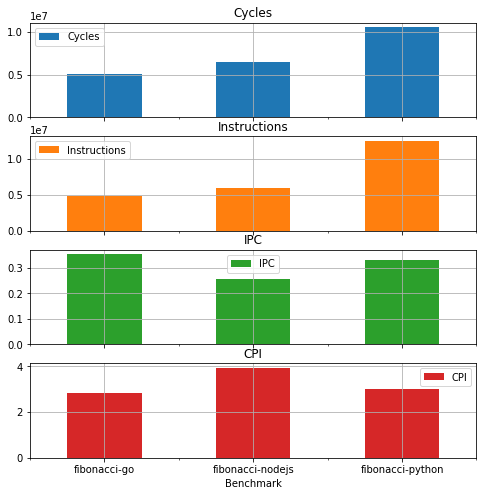

In [40]:
df.plot.bar(x='Benchmark',rot=0,subplots=True, figsize=(8,8), grid=True)